## Práctica Final. Predicciones Diarias Agregadas
### Metodología Facebook Prophet
#### Isabel Marsá Martín

Prophet es una herramienta para realizar predicciones que ha sido desarrollada por Facebook. Utiliza un modelo estadístico basado en series de tiempo para hacer predicciones a futuro. Es fácil de utilizar y puede manejar tanto datos diarios como semanales. Además, Prophet puede manejar cambios en la tendencia y cambios estacionales en los datos. Por ello, utilizaremos Prophet para realizar la predicción de las ventas diarias de la tienda TOSCOS.

In [77]:
# Librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [78]:
# Lectura de datos
data = pd.read_excel('datos_modif.xlsx')
data.tail() 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
9415,T3d,6,2013-01-05,2396.0,338.0,1,0,0,0
9416,T3d,5,2013-01-04,4201.0,553.0,1,0,0,1
9417,T3d,4,2013-01-03,4829.0,644.0,1,0,0,1
9418,T3d,3,2013-01-02,5298.0,689.0,1,0,0,1
9419,T3d,2,2013-01-01,0.0,0.0,0,0,1,1


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9420 entries, 0 to 9419
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          9420 non-null   object        
 1   DayOfWeek      9420 non-null   int64         
 2   Date           9420 non-null   datetime64[ns]
 3   Sales          9420 non-null   float64       
 4   Customers      9420 non-null   float64       
 5   Open           9420 non-null   int64         
 6   Promo          9420 non-null   int64         
 7   StateHoliday   9420 non-null   object        
 8   SchoolHoliday  9420 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 662.5+ KB


In [80]:
# Remplazo los datos de la variable por 1, ya que indica que fue día festivo 
data['StateHoliday'] = data['StateHoliday'].replace(['a', 'b', 'c'], 1)

In [81]:
data=data[['Sales','Customers','StateHoliday', 'SchoolHoliday','Date']]
data=data.groupby('Date').sum()
data.head()

,Sales,Customers,StateHoliday,SchoolHoliday
Date,,,,
2013-01-01,0.0,0.0,10,10
2013-01-02,61926.0,7490.0,0,10
2013-01-03,53588.0,6650.0,0,10
2013-01-04,56578.0,6784.0,0,10
2013-01-05,54938.0,6747.0,0,0


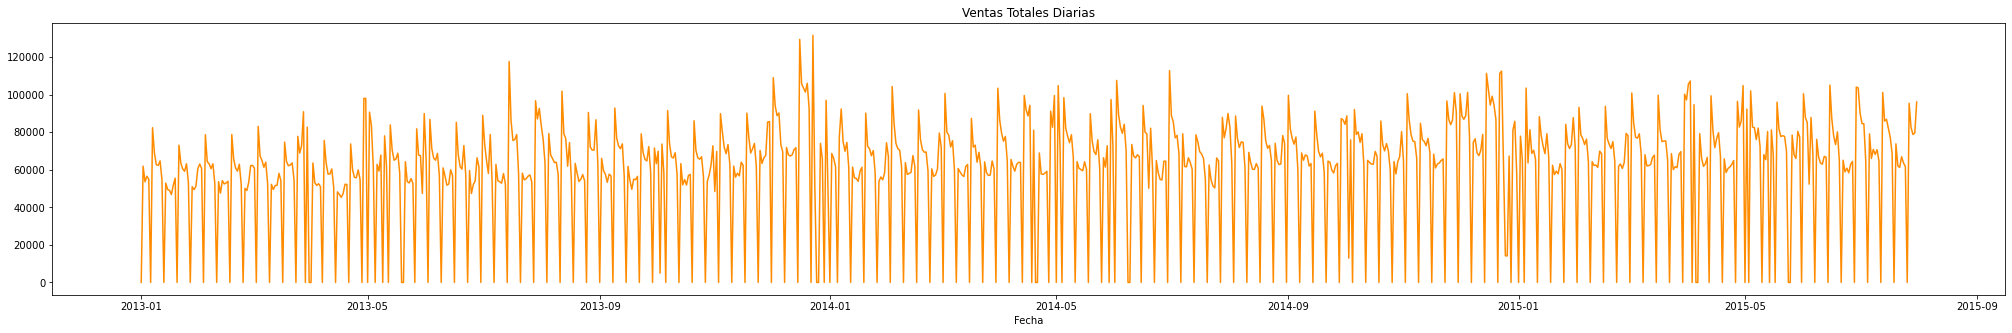

In [82]:
plt.figure(figsize=(35,5))
plt.plot(data['Sales'],color='darkorange')
plt.xlabel('Fecha')
plt.title('Ventas Totales Diarias')
plt.show()

In [83]:
data=data.reset_index()

In [84]:
# Columna ventas
sales = data.loc[:, ['Date', 'Sales']]

# Cambiamos el orden de las fechas
sales = sales.sort_index(ascending = True)

# Pasamos a datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])

sales.dtypes

Date     datetime64[ns]
Sales           float64
dtype: object

In [85]:
# preparamos los datos para que funcione Prophet
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
0,2013-01-01,0.0
1,2013-01-02,61926.0
2,2013-01-03,53588.0
3,2013-01-04,56578.0
4,2013-01-05,54938.0


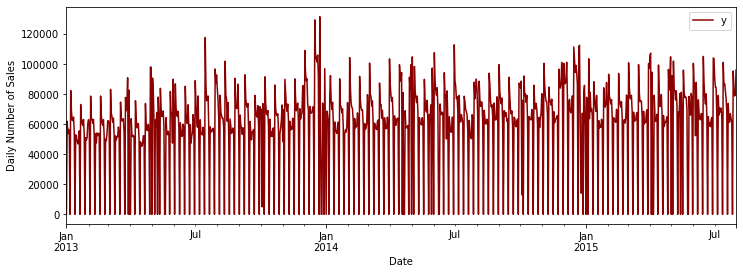

In [86]:
ax = sales.set_index('ds').plot(figsize = (12, 4), color = 'darkred')
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [87]:
# División en train y test. #80%
train = sales.iloc[:754,:]
test = sales.iloc[754:,:]

In [88]:
# Estimación del modelo y lo ajusto con el dataset de entrenamiento (train)
m = Prophet()
m.fit(train)

16:36:49 - cmdstanpy - INFO - Chain [1] start processing
16:36:49 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
# Primero necesitamos el modelo estimado. 
# Como no sabe cuanto espacio tiene que añadir, se lo indicamos
future = m.make_future_dataframe(periods=len(test))
# Predicción del modelo Prophet
forecast = m.predict(future)

Evaluación de la Predicción:

In [90]:
print(r2_score(list(test['y']), list(forecast.loc[754:,'yhat'] )))

0.7083069588184214


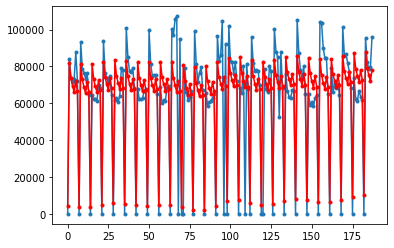

In [91]:
# Gráfico del modelo
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast.loc[754:,'yhat']),'r.-')
plt.show()

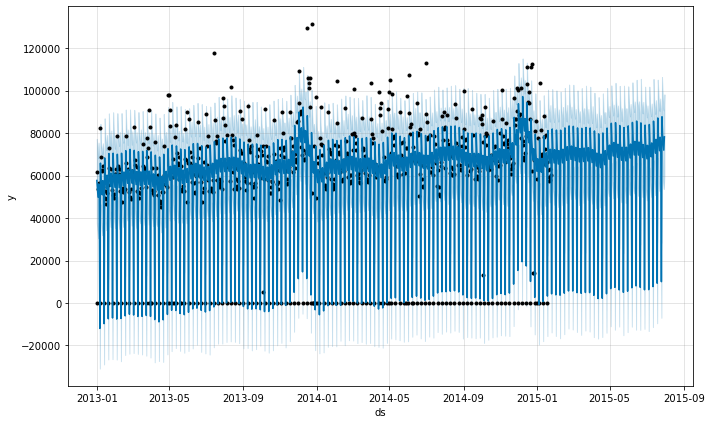

In [92]:
# Gráfico de la predicción
fig1 = m.plot(forecast)
plt.show()

Los puntos son los valores reales. La azul es la predicción

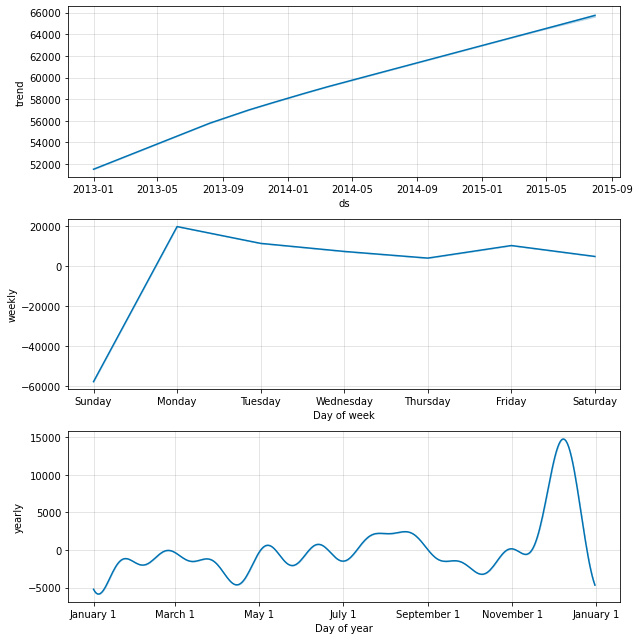

In [93]:
# Gráfico descomposición
fig2 = m.plot_components(forecast)
plt.show()

Añadimos la **estacionalidad**:

In [94]:
m2 = Prophet()
m2.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m2.fit(train)

future2 = m2.make_future_dataframe(periods=len(test))
forecast2 = m2.predict(future)
print(r2_score(list(test['y']), list(forecast2.loc[754:,'yhat'] )))


16:36:52 - cmdstanpy - INFO - Chain [1] start processing
16:36:52 - cmdstanpy - INFO - Chain [1] done processing


0.7138625434170562


Añadimos las fiestas (Holidays):

In [95]:
# Creamos el dataframe festivos (holidays)
# Tenemos 10 tiendas, y consideraremos festivo el día en el que más de 6 tiendas
#  hayan tenido fiesta ese día:

state_dates = data[(data.StateHoliday >6)].loc[:, 'Date'].values
school_dates = data[data.SchoolHoliday > 6].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2013-01-01
1,state_holiday,2013-03-29
2,state_holiday,2013-04-01
3,state_holiday,2013-05-01
4,state_holiday,2013-05-09


In [96]:
m3 = Prophet(holidays=holidays)
m3.fit(train)
future3 = m3.make_future_dataframe(periods=len(test))
forecast3 = m3.predict(future)

16:36:53 - cmdstanpy - INFO - Chain [1] start processing
16:36:53 - cmdstanpy - INFO - Chain [1] done processing


In [97]:
# Evaluación del modelo
print(r2_score(list(test['y']), list(forecast3.loc[754:,'yhat'] )))

0.8781742581265874


In [98]:
# Fijamos el uncertainty interval a 95%. Por defecto en Prophet es 80%
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

my_model.fit(sales)

future_dates = my_model.make_future_dataframe(periods = 6*7)

print("Primera semana de predicción")
future_dates.tail(7)

16:36:54 - cmdstanpy - INFO - Chain [1] start processing
16:36:54 - cmdstanpy - INFO - Chain [1] done processing


Primera semana de predicción


,ds
977,2015-09-05
978,2015-09-06
979,2015-09-07
980,2015-09-08
981,2015-09-09
982,2015-09-10
983,2015-09-11


In [99]:
# predicciones
forecast = my_model.predict(future_dates)

# predicciones ultima semana
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)


,ds,yhat,yhat_lower,yhat_upper
977,2015-09-05,71753.644148,50846.414208,91872.976470
978,2015-09-06,5886.172508,-12565.468433,24568.781838
979,2015-09-07,85160.213267,63492.003417,102079.528932
980,2015-09-08,72738.928429,54878.162502,91528.289781
981,2015-09-09,68762.983630,49226.267787,87911.779929
982,2015-09-10,67157.712831,48647.537966,86361.652997
983,2015-09-11,70804.888126,53951.716552,88650.136600


In [100]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
print('Predicciones desde agosto hasta el 11 de septiembre de 2015:')
fc.tail(42)

Predicciones desde agosto hasta el 11 de septiembre de 2015:


,ds,yhat
942,2015-08-01,77279.198862
943,2015-08-02,13391.151974
944,2015-08-03,93830.611157
945,2015-08-04,82153.668155
946,2015-08-05,78454.851671
947,2015-08-06,76398.871669
948,2015-08-07,78788.100391
949,2015-08-08,69755.084664
950,2015-08-09,4150.319974
951,2015-08-10,84395.051231


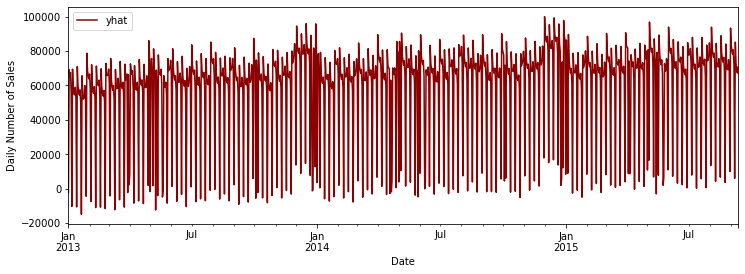

In [101]:
ax = fc.set_index('ds').plot(figsize = (12, 4), color = 'darkred')
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [102]:
fc.to_excel('fc_prophet.xlsx',index=True)  

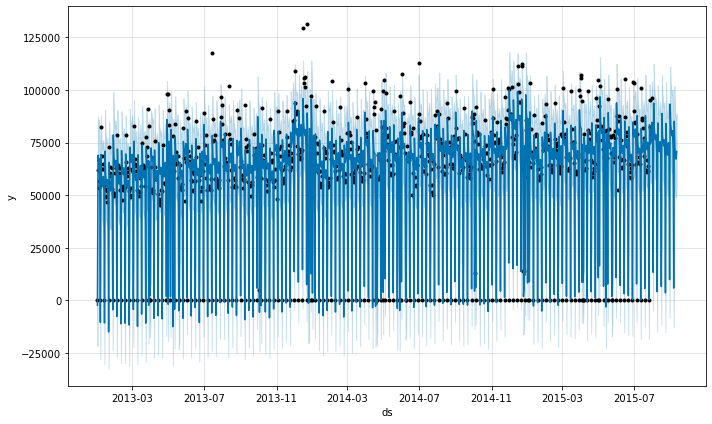

In [103]:
# visualizing predicions
my_model.plot(forecast);

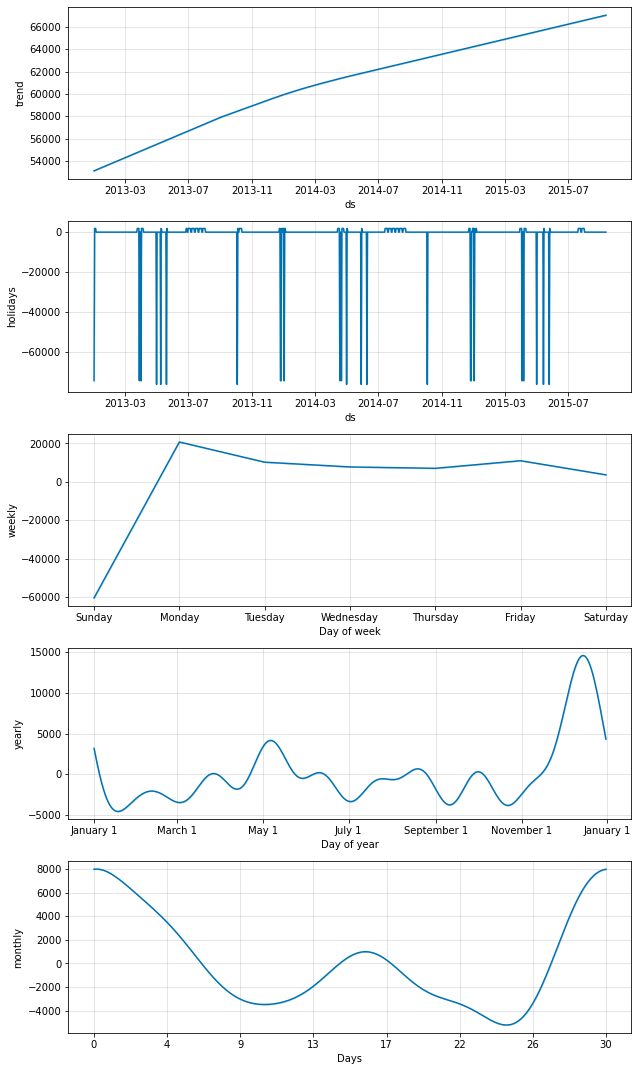

In [104]:
my_model.plot_components(forecast);

En el primer gráfico observamos que el total de las ventas de las tiendas han ido incrementando linealmente a lo largo de los meses. El segundo gráfico muestra los festivos incluidos en el modelo. El tercer gráfico muestra que el pico de ventas se da los lunes, y que los domingos no hay ventas y el cuarto gráfico muestra que la época de más ventas es Navidad, es decir, diciembre y enero. Por último, el último gráfico señala que los días del mes que más ventas hay es entre los días 1 y 4 y los últimos del mes.